In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast

from darts                              import TimeSeries
from darts.models                       import LinearRegressionModel
from darts.dataprocessing.transformers  import Scaler

from sklearn.metrics import mean_squared_error

In [24]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [25]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings


pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

#split data in train val and test
split = len(pdf)-450
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+225], pdf.iloc[split+225:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_1412\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


In [26]:
ytrain = TimeSeries.from_dataframe(pdf_train)
yval   = TimeSeries.from_dataframe(pdf_val)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)
ytotal

<TimeSeries (DataArray) (Timestamp: 3107, component: 1, sample: 1)>
array([[[6.70908714]],

       [[7.07334784]],

       [[7.14954415]],

       ...,

       [[5.75060674]],

       [[7.02940656]],

       [[6.82616489]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-07-04
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [45]:
encoders = {"datetime_attribute": {"future": ["dayofweek","month", "year"]},"transformer": Scaler()}
#the transformer in the dict above is for the encoder and not for the data. 

In [46]:
model = LinearRegressionModel(lags=180,
                              add_encoders=encoders
                              )


model.fit(series=ytrain)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


LinearRegressionModel(lags=180, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['dayofweek', 'month', 'year']}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [44]:
import inspect
# getmembers() returns all the
# members of an object
for i in inspect.getmembers(model)[100:]:
    if i[0].startswith('supports') == True:
        print(i[0],i[1])

    if i[0].startswith('uses') == True:
        print(i[0],i[1])

#stange why does the model support covariates

supports_future_covariates True
supports_past_covariates True
supports_static_covariates True
uses_future_covariates False
uses_past_covariates False
uses_static_covariates False


In [47]:
y_pred = model.predict(n=int(len(ytest)), series=ytrain)
y_pred = y_pred.pd_series()

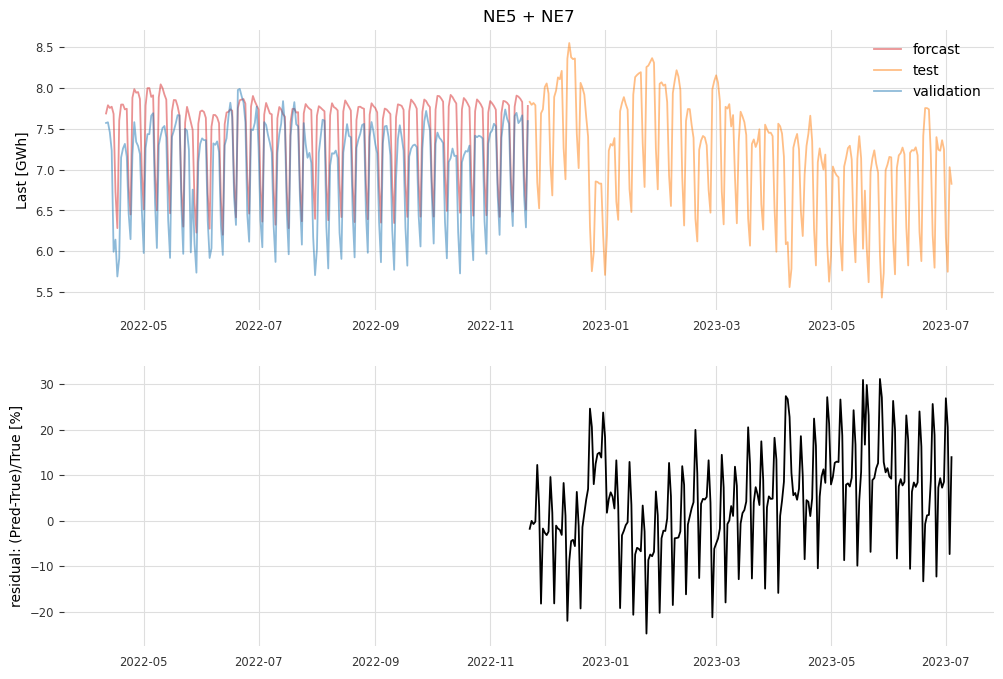

In [49]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(y_pred, color="tab:red", label="forcast", alpha=0.5)
# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="test", alpha=0.5)
axes[0].plot(pdf_val, color="tab:blue", label="validation", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

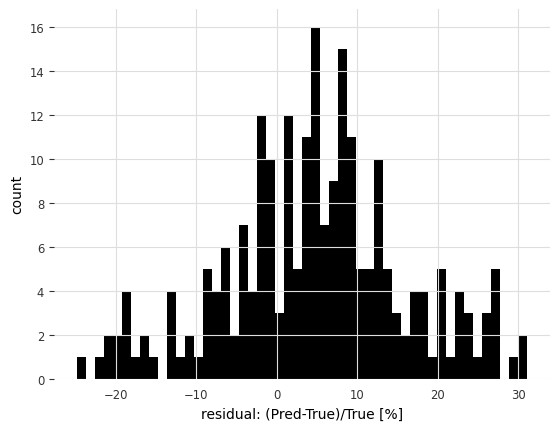

In [50]:
#histogramm of the residuals

plt.hist((y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100, bins=50)
plt.xlabel("residual: (Pred-True)/True [%]")
plt.ylabel("count")
plt.show()

In [51]:
validation_prediction = model.predict(n=len(yval), series=ytrain).pd_series().values
rmse = mean_squared_error(pdf_val.y.values,validation_prediction, squared=False)
print(f"RMSE on validation set: {rmse:.3f}")

RMSE on validation set: 0.480


In [52]:
rmse = mean_squared_error(pdf_test.y.values, y_pred.values, squared=False)
print(f"RMSE on test set: {rmse:.3f}")


RMSE on test set: 0.821
